In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import pandas_datareader.data as web
import datetime as dt

stock = 'IBM'
start = dt.datetime(2000,3,26)
end = dt.datetime(2021,3,13)
data_source = 'yahoo'

df = web.DataReader(stock, data_source, start, end).reset_index()

In [ ]:
import pandas_datareader.data as web
import datetime as dt

# Add more stock symbol sanes
STOCKS = [
    'AAPL', 'WMT', 'MSFT', 'GOOGL', 'BA', 'GE', 'EQX', 'SBUX', 'GM', 
    'NFLX', 'HD', 'NEE', 'NKE'
]


df_accumulator = []
for stock in STOCKS:
    try:
        start = dt.datetime(2000,3,26)
        end = dt.datetime(2021,3,13)
        data_source = 'yahoo'

        df = web.DataReader(stock, data_source, start, end).reset_index()
        df_accumulator.append(df)
    except:
        print(stock, 'not available')


df = pd.concat(df_accumulator)
print('total data size:', len(df))

total data size: 59518


In [ ]:
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [ ]:
#df = df.set_index('Date')
df.drop(['Date'], axis=1, inplace=True)

In [ ]:
# concatenate all features
df_concat = df
df_concat = df_concat.dropna()
df_concat.shape

(59518, 6)

In [ ]:
feat_size = df_concat.shape[1]

print('feature size:', feat_size)

feature size: 6


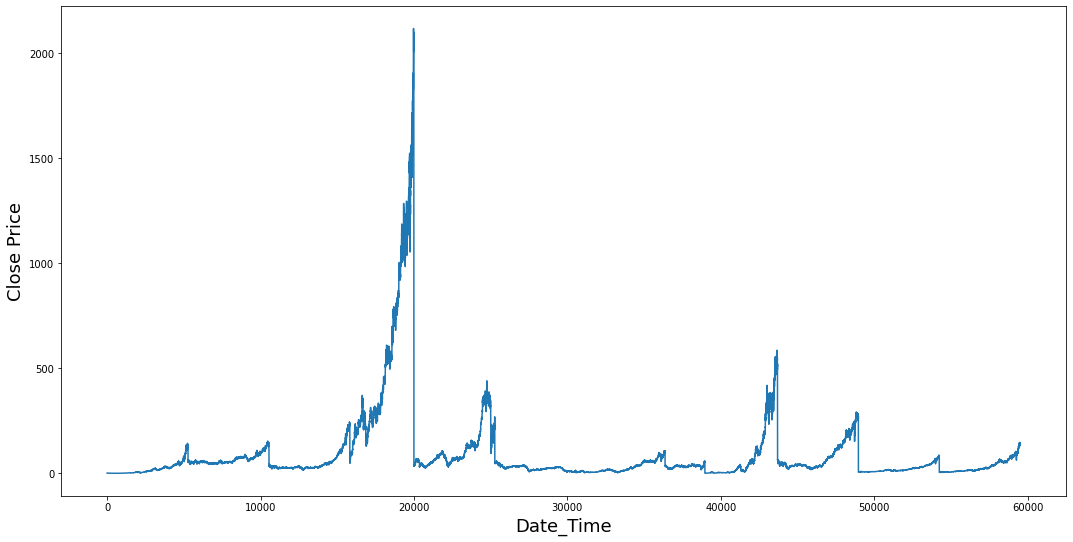

In [ ]:
plt.figure(figsize = (18,9))
#plt.plot(df_concat['Close'])
plt.plot(range(df_concat.shape[0]),(df_concat['Close']))
#plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date_Time',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [ ]:
df_concat.head()

,High,Low,Open,Close,Volume,Adj Close
0,1.292411,1.222098,1.228795,1.246094,279182400.0,1.073340
1,1.267857,1.224330,1.225446,1.242188,202966400.0,1.069975
2,1.244978,1.194894,1.244420,1.213728,239836800.0,1.045461
3,1.229353,1.119978,1.192522,1.122768,414400000.0,0.967112
4,1.225446,1.125000,1.137835,1.212612,404633600.0,1.044500


In [ ]:
# how long preceding sequence to consider for prediction
SEQ_LEN = 60            

# How far into the future we are making prediction(10 min in this case)
FUTURE_PERIOD = 10

RATIO_TO_PREDICT = "Close"

In [ ]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [ ]:
times = sorted(df_concat.index.values)  # get the times
last_10 = sorted(df_concat.index.values)[-int(0.1*len(times))] 
last_20 = sorted(df_concat.index.values)[-int(0.2*len(times))]

test_df = df_concat[(df_concat.index >= last_10)]
validation_df = df_concat[(df_concat.index >= last_20) & (df_concat.index < last_10)]  
train_df = df_concat[(df_concat.index < last_20)]

In [ ]:
len(train_df), len(validation_df), len(test_df)

(47610, 5948, 5960)

In [ ]:
from collections import deque
import numpy as np
import random

In [ ]:
train_ = train_df.values
valid_ = validation_df.values
test_ = test_df.values

In [ ]:
print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))

train shape (47610, 6)
valid shape (5948, 6)
test shape (5960, 6)


In [ ]:
scaler = MinMaxScaler()
scale_close = MinMaxScaler()

In [ ]:
x = train_[:,3].copy()
scale_close.fit(x.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaler.fit(train_)

train_ = scaler.transform(train_)
valid_ = scaler.transform(valid_)
test_ = scaler.transform(test_)

In [ ]:
# Now perform exponential moving average smoothing for smooth curve of data
EMA = 0.0
gamma = 0.1
for ti in range(len(train_)):
    EMA = gamma*train_[ti] + (1-gamma)*EMA
    train_[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_,valid_, test_],axis=0)

In [ ]:
def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])
    return np.array(X), np.array(Y)

In [ ]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], feat_size))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], feat_size))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], feat_size))

In [ ]:
y_train.shape

(47541,)

In [ ]:
print("train shape {0}".format(X_train.shape))
print("valid shape {0}".format(X_valid.shape))
print("test shape {0}".format(X_test.shape))

train shape (47541, 60, 6)
valid shape (5879, 60, 6)
test shape (5891, 60, 6)


In [ ]:
X_train_2, y_train_2 = split_data(train_)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], feat_size))

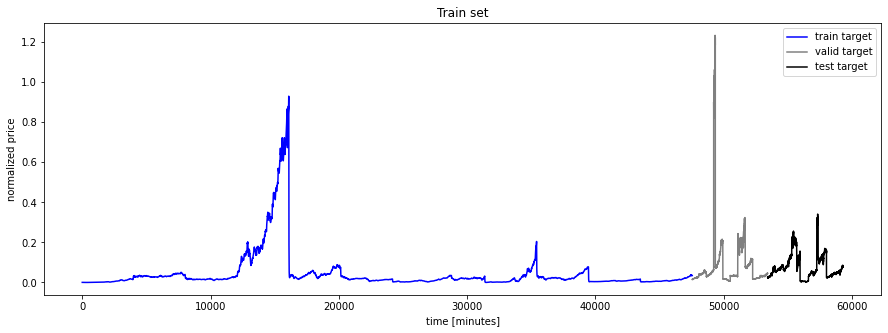

In [ ]:
"""
splitted data
"""

plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Train set')
plt.xlabel('time [minutes]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
EPOCHS = 60
BATCH_SIZE = 256

import time

In [ ]:
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer

In [ ]:
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

In [ ]:
class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

In [ ]:
class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

    
class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn
    
    
def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

In [ ]:
class CustomeLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomeLearningSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        param_1 = tf.math.rsqrt(step)
        param_2 = step * (self.warmup_steps**(-1.5))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(param_1, param_2)

Text(0.5, 0, 'Train Step')

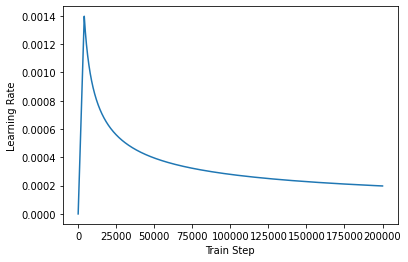

In [ ]:
sample_learning_rate = CustomeLearningSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
D_MODEL=300

lr = CustomeLearningSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
def build_model():
    inp = Input(shape = (SEQ_LEN, feat_size))

    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    #for i in range(2):
    x, self_attn = EncoderLayer(
            d_model=D_MODEL,
            d_inner_hid=512, 
            n_head=4, 
            d_k=64,
            d_v=64, 
            dropout=0.2)(x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(128, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error",  
        optimizer = optimizer)
    
    return model

In [ ]:
multi_head = build_model()
multi_head.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 6)]      0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 256)      138240      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 60, 128)      164352      bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 60, 256)      32768       bidirectional_3[0][0]            
____________________________________________________________________________________________

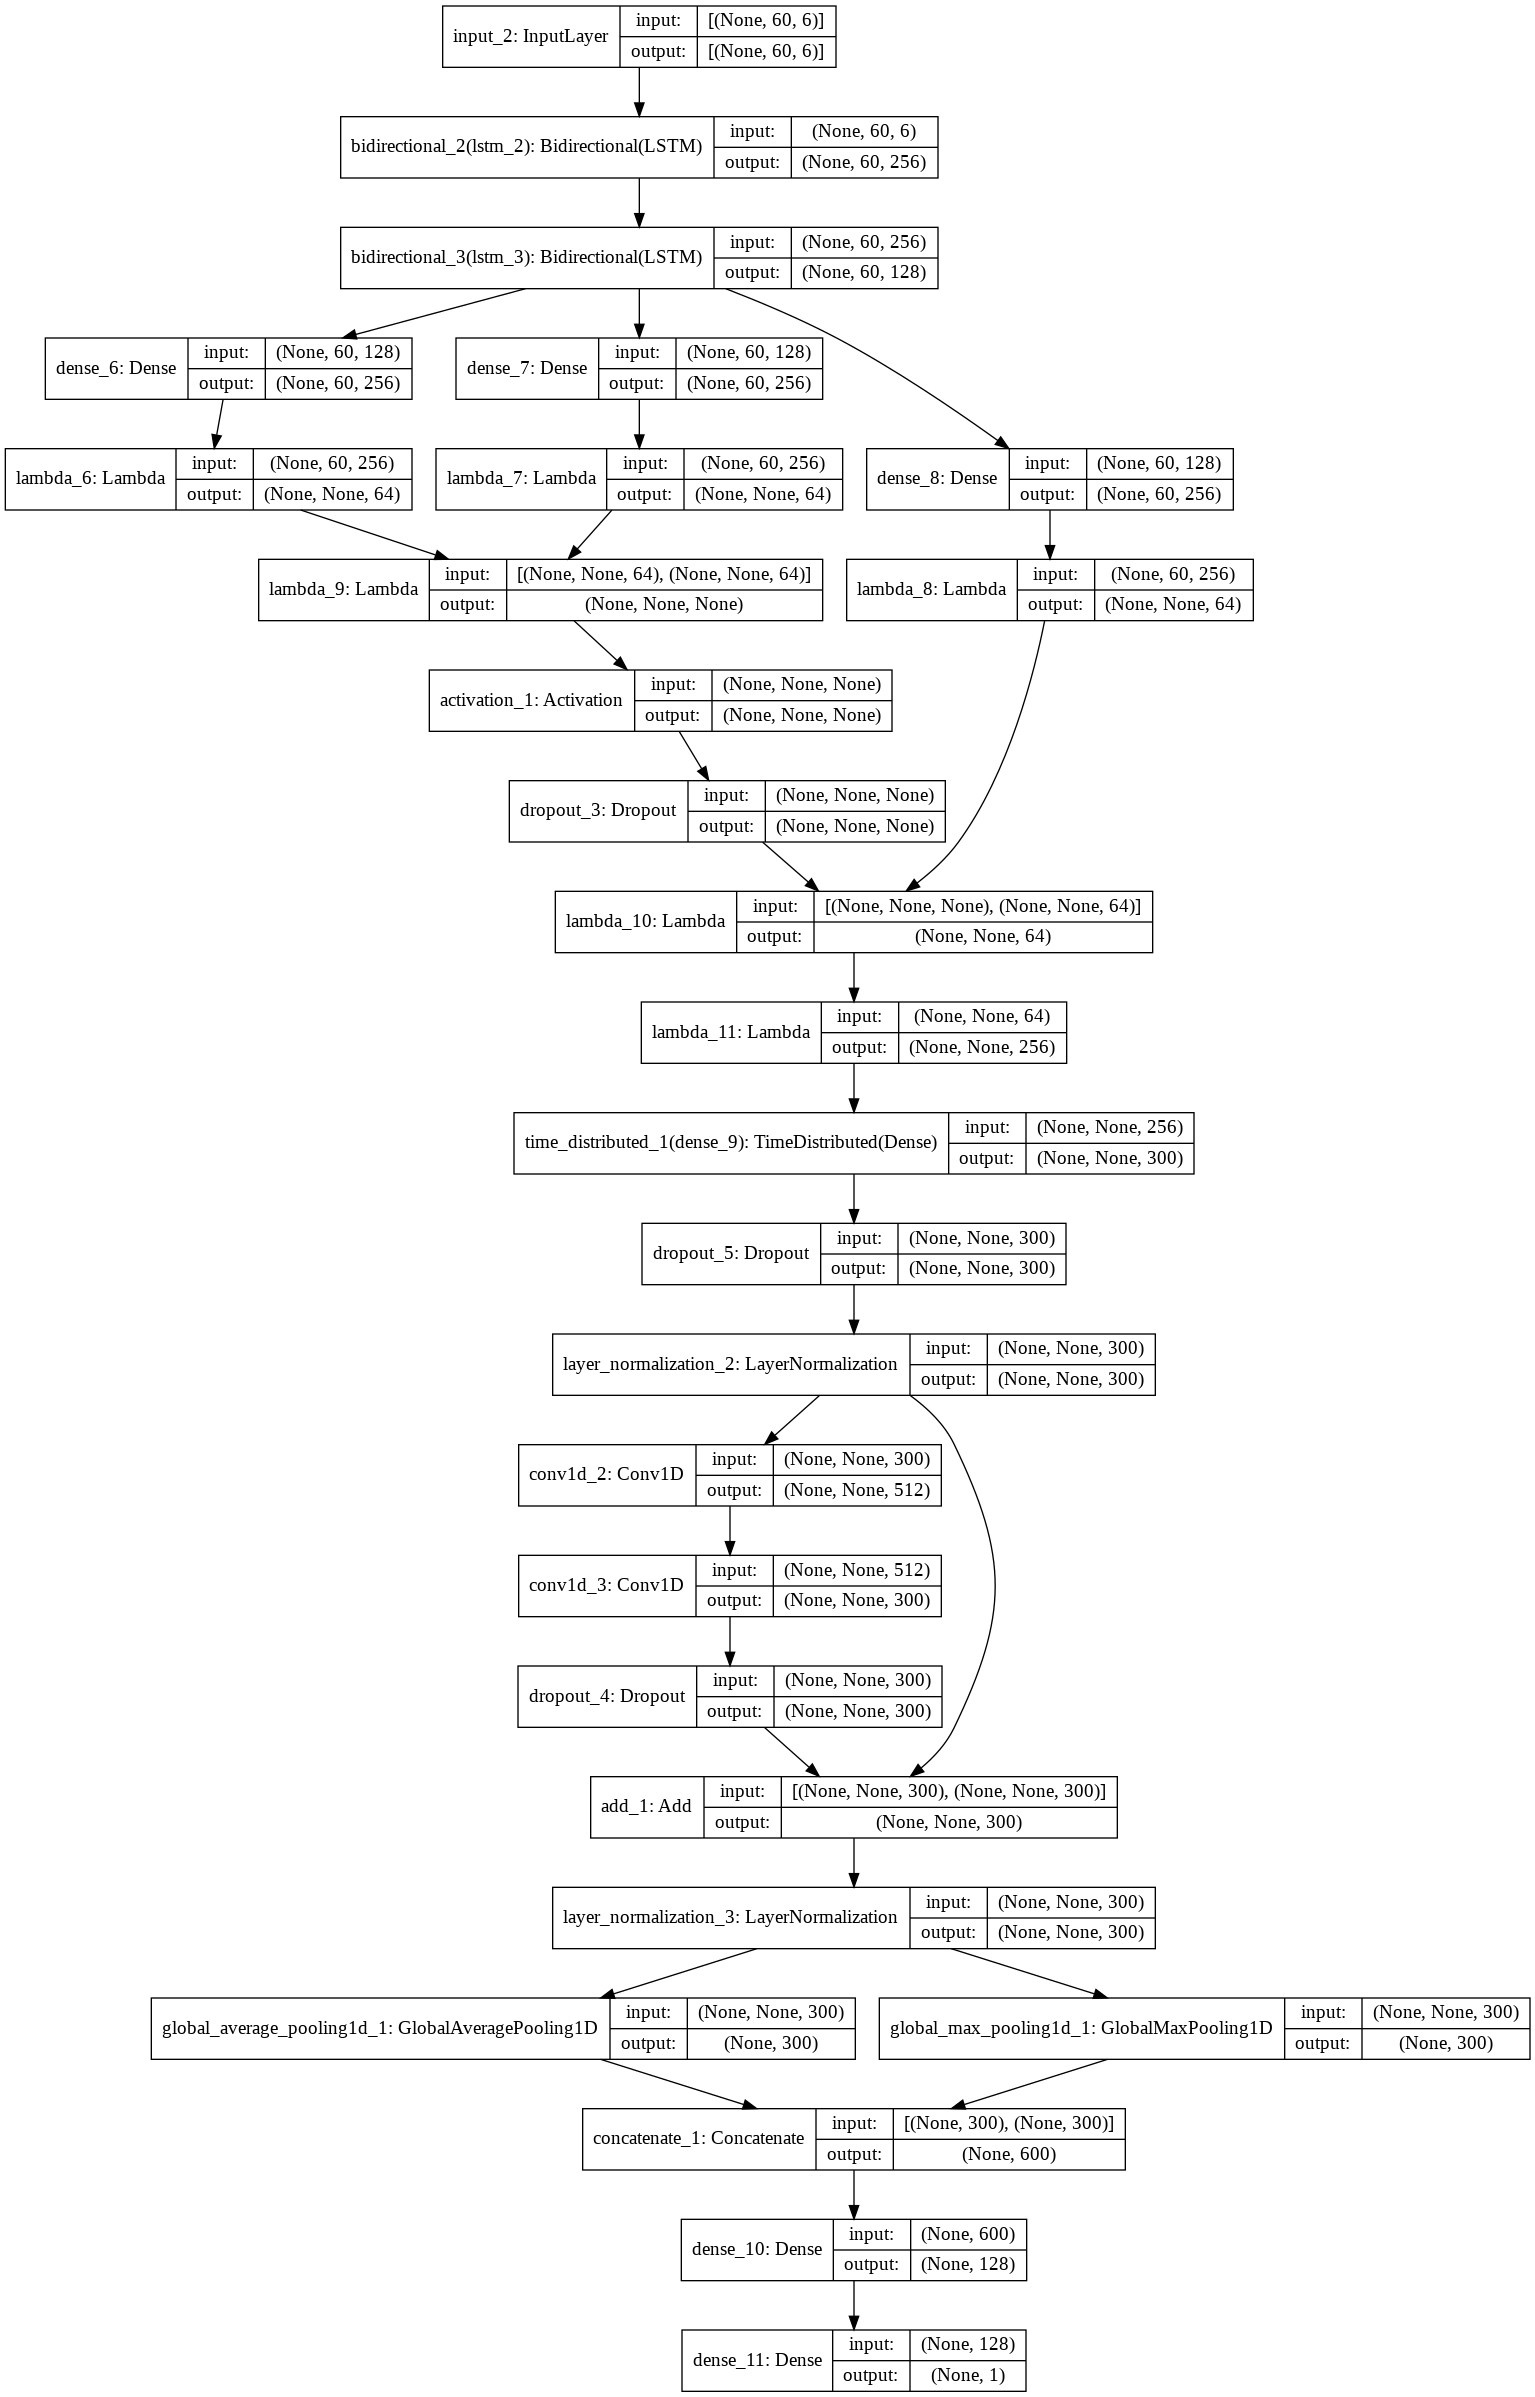

In [ ]:
tf.keras.utils.plot_model(multi_head, 
                          to_file="multi_head_net.png", 
                          show_shapes=True)

In [ ]:
"""
TRAINING
"""


callback = EarlyStopping(monitor='val_loss',
                         patience=3,
                         restore_best_weights=True)

In [ ]:
history = multi_head.fit(x=X_train, 
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_valid, y_valid), 
                         callbacks=[callback])

Epoch 1/60
186/186 [==============================] - 20s 77ms/step - loss: 0.2251 - val_loss: 0.0119
Epoch 2/60
186/186 [==============================] - 13s 70ms/step - loss: 6.5963e-04 - val_loss: 0.0090
Epoch 3/60
186/186 [==============================] - 13s 68ms/step - loss: 6.1928e-04 - val_loss: 0.0068
Epoch 4/60
186/186 [==============================] - 13s 68ms/step - loss: 4.9976e-04 - val_loss: 0.0066
Epoch 5/60
186/186 [==============================] - 13s 68ms/step - loss: 5.4421e-04 - val_loss: 0.0071
Epoch 6/60
186/186 [==============================] - 13s 68ms/step - loss: 3.5114e-04 - val_loss: 0.0062
Epoch 7/60
186/186 [==============================] - 13s 68ms/step - loss: 2.2637e-04 - val_loss: 0.0081
Epoch 8/60
186/186 [==============================] - 13s 69ms/step - loss: 1.8728e-04 - val_loss: 0.0067
Epoch 9/60
186/186 [==============================] - 13s 69ms/step - loss: 2.4958e-04 - val_loss: 0.0065


In [ ]:
multi_head.save_weights('./checkpoints/final_checkpoint_1')

In [ ]:
multi_head.load_weights('./checkpoints/final_checkpoint_1')

In [ ]:
predicted_stock_price_multi_head = multi_head.predict(X_test)
#predicted_stock_price_multi_head = scaler.inverse_transform(predicted_stock_price_multi_head)


predicted_stock_price_multi_head.shape

(5891, 1)

In [ ]:
predicted_stock_price = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))

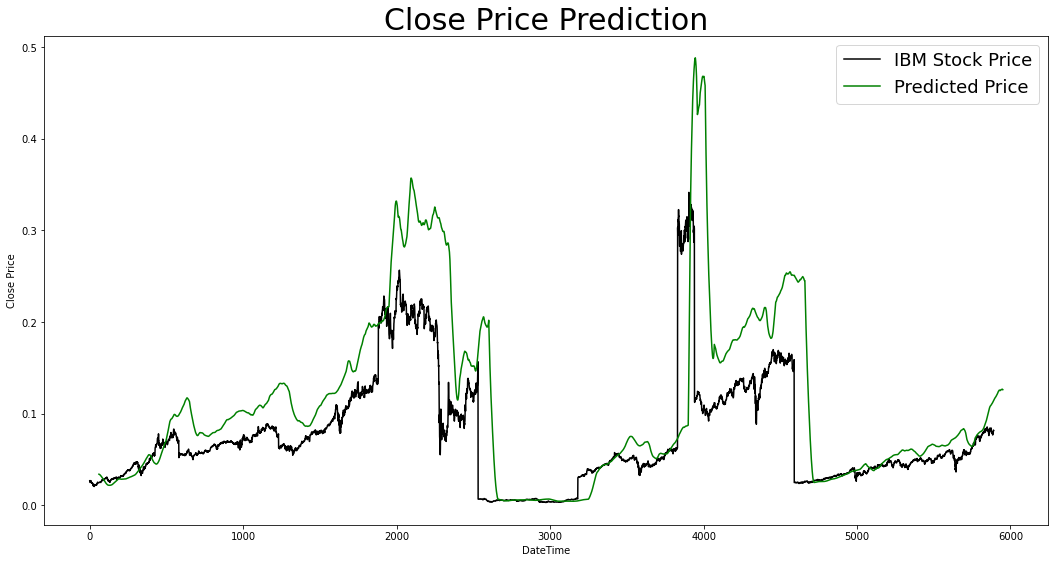

In [ ]:
plt.figure(figsize = (18,9))

plt.plot(y_test, color = 'black', label = 'IBM Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)

plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()